# Clustering synthesis methods by similarity
Use this notebook to explain what SnyOracle is and does in a specific ordered fashion

In [63]:
%colors nocolor

In [64]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns
from matplotlib.patches import Ellipse

try:
    from synoracle import sequence, ingredients
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

In [65]:
with open('./broken_down_boms.json', 'r', encoding='utf-8') as f:
    rawdata = json.loads(f.read())

left = pd.DataFrame(rawdata).set_index('level_0')
left.index = left.index.rename('pubchem_id').astype(int)

In [66]:
with open('./chemical_typing_crossreference.json', 'r', encoding='utf-8') as f:
    xref = json.loads(f.read())
right = pd.DataFrame(xref)
right.index = right.index.rename('pubchem_id').astype(int)

In [67]:
all_boms = pd.merge(left=left, right=right, left_index=True, right_index=True)

In [68]:
all_boms[(all_boms['synthesis_number']==0) & (all_boms['step type']=='add')]

,step type,name,moles,synthesis_number,index,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent
pubchem_id,,,,,,,,,,,,,,,,,,
962,add,[H2O],1.101671,0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
12749,add,[2-methylimidazole],0.002000,0,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False
24821,add,[Co(NO3)2·6H2O],0.000500,0,2.0,False,True,False,False,False,False,False,True,False,False,False,False,False
5462310,add,[carbon],0.004995,0,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False


In [69]:
all_syn_chems = {}
counter = 0
counter_to_synthesis_map = {}
for syn_index in li_iterate(all_boms['synthesis_number'].unique()):
    syn_chems = []
    filters = ['contains_cobalt',
                  'contains_zinc',
                  'contains_sulfate',
                  'contains_chloride',
                  'contains_nitrate',
                  'contains_oxide',
                  'contains_acetate']
    working = all_boms[all_boms['synthesis_number']==syn_index]
  
    filtered_working = working[(~np.where(
        working['contains_cobalt'] | working['contains_zinc'] | \
        working['contains_sulfate'] | working['contains_chloride'] |\
        working['contains_nitrate'] | working['contains_oxide'] |\
        working['contains_acetate'] | working['contains_imidazole'],
        True, 
        False)) & (working['step type']=='add')]
   # display(list(set(filtered_working.index)))
    if 12749 in working.index:
        for x in filters:
            if not working[working[x]].empty:
                syn_chems.append(x)
        syn_chems.extend(
            [y for y in list(set(filtered_working.index))]
        )

        # print(syn_chems)

        all_syn_chems[counter] = ' '.join(sorted([str(x) for x in syn_chems]))
        counter_to_synthesis_map[counter] = syn_index
        counter +=1

  0%|          | 0/1599 [00:00<?, ?it/s]

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

words_rep = pd.DataFrame(all_syn_chems, index=['Name']).T.reset_index().rename({'index': 'synthesis_number'}, axis=1)
words_rep['source'] = 'els-rsc'


vectorizer = TfidfVectorizer(analyzer='word')
X = vectorizer.fit_transform(words_rep['Name'])

pickle.dump(vectorizer.vocabulary_,open('./tfidfvectors.pkl', 'wb'))
pd.concat([words_rep,pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())], axis=1).head()


,synthesis_number,Name,source,10005,1004,10154203,1118,11251951,11281299,1133,...,944,947,962,contains_acetate,contains_chloride,contains_cobalt,contains_nitrate,contains_oxide,contains_sulfate,contains_zinc
0,0,2 5974 887 contains_acetate contains_cobalt co...,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.524862,0.0,0.314599,0.194086,0.0,0.0,0.224731
1,1,702 887 contains_acetate contains_cobalt conta...,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.580624,0.0,0.348022,0.214706,0.0,0.0,0.000000
2,2,2 887 contains_acetate contains_cobalt contain...,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.766269,0.0,0.459297,0.283355,0.0,0.0,0.000000
3,3,2 4 887 contains_acetate,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.910192,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,4,2 887 contains_nitrate,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.630646,0.0,0.0,0.000000


In [159]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.39, min_samples=20).fit(X.toarray())
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 9
Estimated number of noise points: 544


In [160]:

def solvent_map(x: str)->str:
    if ('887' in x) & ('962' in x):
        return 'turquoise'
    if '887' in x:
        return 'blue'
    if '962' in x:
        return 'green'
    if '6228' in x:
        return 'red'
    if '702' in x:
        return 'purple'
    return 'k'

def metal_map(x:str)->str:
    if ('cobalt' in x) & ('zinc' in x):
        return 'purple'
    if ('zinc' in x):
        return 'red'
    if ('cobalt' in x):
        return 'blue'
    return 'k'

def salt_map(x:str) ->str:
    #mutliple
    if not ('nitrate' in x)^('oxide' in x)^('acetate' in x)^('sulfate' in x)^('chloride' in x):
        return 'k'
    if 'nitrate' in x:
        return 'blue'
    if 'oxide' in x:
        return 'green'
    if 'acetate' in x:
        return 'red'
    if 'sulfate' in x:
        return 'turquoise'
    if 'chloride' in x:
        return 'pink'
    return 'k'

zinc_encoding = words_rep['Name'].apply(metal_map)
salt_encoding = words_rep['Name'].apply(salt_map)
solvent_encoding = words_rep['Name'].apply(solvent_map)
solvent_encoding.unique()

array(['blue', 'green', 'purple', 'k', 'red', 'turquoise'], dtype=object)

## DBSCAN clustering and TSNE visualisation

c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


-44.37887 4.942605
-37.016487 1.4699833
-55.96292 1.0809817
55.042877 3.1341515
28.442581 0.7380538
-18.507603 1.5819926
-2.5792274 1.0852456
13.375079 1.3798331
-33.57984 0.8159422


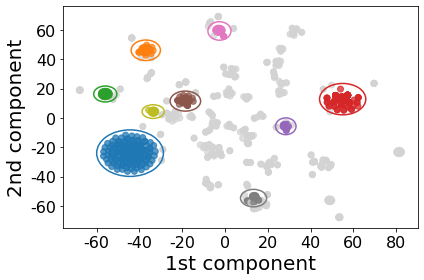

In [163]:
from sklearn.manifold import TSNE
# Create a TSNE instance: model
model = TSNE( metric='euclidean', perplexity=10, n_iter=5000, random_state=25, early_exaggeration=12) 

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(X.toarray())

# Select the 0th feature: xs
xs = tsne_features[:, 0]

# Select the 1st feature: ys
ys = tsne_features[:, 1]

# Scatter plot, coloring by variety_numbers
new_color_map = dict(zip(range(0,10), cm.tab10.colors))
new_color_map[-1] = 'lightgray'

fig, ax = plt.subplots()
ax.scatter(xs, ys, alpha=0.75, c = [new_color_map[x] for x in labels])

for x in np.unique(labels):
    if x == -1:
        continue
    clust_x = xs[labels == x]
    clust_y  =  ys[labels == x]
    print(np.mean(clust_x), np.std(clust_x))
    el1 = Ellipse(
        (np.mean(clust_x),np.mean(clust_y)),
        max(clust_x)-min(clust_x)+7,
        max(clust_y)-min(clust_y)+7,
          # 7.5*np.std(clust_x),
          # 7.5*np.std(clust_y),
        facecolor='none',
          edgecolor=new_color_map[x],
          linewidth=1.5)
    ax.add_artist(el1)

ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=16)
ax.set_ylabel('2nd component', fontsize=20)
ax.set_xlabel('1st component', fontsize=20)

plt.tight_layout()
plt.savefig('Fig 7.png', dpi=900)

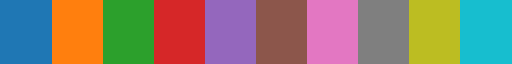

Label number: 0
Colour: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Number of syntheses: 225
Chemicals contained: 887 contains_nitrate contains_zinc
------------
Label number: 1
Colour: (1.0, 0.4980392156862745, 0.054901960784313725)
Number of syntheses: 39
Chemicals contained: contains_nitrate contains_zinc
------------
Label number: 2
Colour: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
Number of syntheses: 31
Chemicals contained: 887 contains_cobalt contains_nitrate contains_zinc
------------
Label number: 3
Colour: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
Number of syntheses: 147
Chemicals contained: 887 contains_cobalt contains_nitrate
------------
Label number: 4
Colour: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
Number of syntheses: 22
Chemicals contained: 962 contains_acetate contains_zinc
------------
Label number: 5
Colour: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
Number of synthes

In [162]:
from collections import Counter
lbl_no = 7
display(cm.tab10)
for x in np.unique(labels):
    if x == -1:
        continue
    output = ''
    output += f'Label number: {x}\n'
    output += f'Colour: {new_color_map[x]}\n'
    label_items = Counter(words_rep['Name'][labels==x]).most_common()[0]
    output += f'Number of syntheses: {label_items[1]}\n'
    output += f'Chemicals contained: {label_items[0]}\n------------'
    print(output)
